In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from visualisation import Analysis

In [2]:
analysis = {}
##############################################################################
################Input File Name and Plotting Steps############################
##############################################################################
start_time = datetime.now()

#File1 = '6e6_sHFPN_Healthy_SD_0_DelaySD_01'
File2 = '6e6_sHFPN_Healthy_SD_0_DelaySD_0'
#File3 = '10e6_sHFPN_Healthy_SD_01_DelaySD_0_RUN_2'
desired_plotting_steps = 6000000

#analysis[File1] = Analysis.load_from_file(File1)
analysis[File2] = Analysis.load_from_file(File2)
#analysis[File3] = Analysis.load_from_file(File3)

execution_time = datetime.now()-start_time
print('\n\nLoad-in Time:', execution_time)
print("")
##############################################################################
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~End - BSL~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
##############################################################################   



Load-in Time: 0:00:24.628680



In [13]:
def smoothen(array, filter_size):
    filt=np.ones(filter_size)/filter_size
    return convolve(array[:-(filter_size-1),0],filt)
    
def create_plot(analysis, input_place_list, place_labels, mutation_list, mutation_labels, plot_title):
    t=np.arange(0,(desired_plotting_steps/1000)+0.001,0.001) #

    fig,ax=plt.subplots()
    linestep = 0.3
    line_width = 2.5
    
    for i, mutation in enumerate(mutation_list):
        for place, place_label in zip(input_place_list, place_labels):
            data = analysis[mutation].mean_token_history_for_places([place])[0:desired_plotting_steps+1] #mutation is the file_name
            #print(data[1600000]) #units in time_step
            #print(data[1800000])
            if place_label == "":
                ax.plot(t, data, label = mutation_labels[i], linewidth = line_width- i*linestep, color="black")
            else:
                ax.plot(t, data, label = mutation_labels[i]+' - '+place_label, linewidth = line_width- i*linestep, color="black")
    
    ax.legend()
    Analysis.standardise_plot(ax, title = plot_title, xlabel = "Time (s)",ylabel = "Molecule count")
    
##############################################################################
############## OTHER PLOT PARAMETERS YOU WANT#################################
##############################################################################
    #plt.xlim([0,2500]) #x axis range in seconds
    #plt.ylim([4.335e8,4.345e8]) #y axis range in tokens
    #plt.ylim([0,50])
    
    #DASHED LINES
    # plt.axvline(x=1500, linestyle='--', color ='black')
    # plt.axvline(x=1550, linestyle='--', color ='black')
    #plt.axhline(y=4.34*1e8, linestyle='--', color ='red', label = "fc_t_SNCA_bind_ApoEchol_extra Threshold = 4.34*1e8")
    #plt.axhline(y=10,linestyle='--', color ='red', label ="LB Threshold")
    
    #plt.axhline(y=10,linestyle='--', color ='red', label ="LB Threshold, xmin=0, xmax=1000")
    
    #plt.legend()
##############################################################################
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~End - BSL~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
##############################################################################    
    plt.show()

def plot_stacked_bars(ax, legend, all_data, xs, labels, width):

    cum_sum = np.zeros_like(all_data[:,0])
    for i in range(len(labels)):
        data = all_data[:,i]
        rects = ax.bar(xs, data, width, bottom=cum_sum, label=labels[i])
        cum_sum += data    
    
def create_bar_chart(analysis, places_a, places_a_labels, places_b, places_b_labels, mutation_list, mutation_labels, plot_title):
#     for mutation in mutation_list:
#         for place in places_a:
#             print(place)
#             print(analysis[mutation].mean_token_history_for_places(place)[-1])
#     for mutation in mutation_list:
#         for place in places_b:
#             print(place)
#             print(analysis[mutation].mean_token_history_for_places(place)[-1])
    final_token_count_a = [[analysis[mutation].mean_token_history_for_places(place)[-1] for place in places_a] for mutation in mutation_list]
    final_token_count_b = [[analysis[mutation].mean_token_history_for_places(place)[-1] for place in places_b] for mutation in mutation_list]
    print(np.array(final_token_count_a).shape)
    print(np.array(final_token_count_b).shape)
    final_token_count_a = np.sum(final_token_count_a, 2) # remove dimension 3
    final_token_count_b = np.sum(final_token_count_b, 2) # remove dimension 3

    # normalize data

    final_token_count_a = final_token_count_a / np.sum(final_token_count_a[0,:])
    final_token_count_b = final_token_count_b / np.sum(final_token_count_b, 1)[:,None]

    final_token_count_a *= 100
    final_token_count_b *= 100
    
    width = 0.5
    
    FIGURESIZE = (14,7)
    fig, ax = plt.subplots(1, 1, figsize=FIGURESIZE)

    bar_positions_a = np.array(range(len(mutation_list)))
    bar_positions_b = max(bar_positions_a) + 2 + np.array(range(len(mutation_list)))
    
    plot_stacked_bars(ax,legend=mutation_list, all_data=final_token_count_a, xs=bar_positions_a, labels=places_a_labels,width=width)
    plot_stacked_bars(ax,legend=mutation_list, all_data=final_token_count_b, xs=bar_positions_b, labels = places_b_labels,width=width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% Molecule Count', fontsize=16)
    ax.set_title(plot_title, fontsize=18)
    ax.set_xticks(np.concatenate((bar_positions_a, bar_positions_b)))
    ax.set_xticklabels(np.concatenate((mutation_labels, mutation_labels)), rotation=-25, ha='left', fontsize=12)

    #ax.set_ylim((0,150))

    plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()
    
##############################################################################
################Other Relevant Graphs - BSL###################################
##############################################################################
    
def calculate_mean_per_bin(file, place_id, bin_width):
    """
    bin_width should be in time_steps and total timesteps/bin_width should equal an integer
    """
    data = analysis[file].mean_token_history_for_places([place_id])[0:desired_plotting_steps+1]
    bin_number = desired_plotting_steps/bin_width
    start = 0
    end = bin_width
    list_of_means = []
    for item in range(int(bin_number)):
        list_of_means.append(np.mean(data[start:end]))
        start = start + bin_width
        end = end + bin_width
    return list_of_means

    
    

##############################################################################
################END ##########################################################
##############################################################################    
    
##############################################################################
################Calcium Relevant Graphs - BSL#################################
##############################################################################

def create_histogram(analysis, bins):
    plt.hist(analysis[File1].delay_list_t_B, bins=bins, edgecolor='black', linewidth=1.2)
    print("NOTE, these are t_B transitions only")
    
def calc_mean_SD_transition(list_of_transition_delays, transition_id):
    """
    So the delays for each transition t_A, t_B t_D were compiled into a list for analysis. We are just calculating the mean and standard deviation for those lists here.
    """
    the_mean_t_A = np.mean(list_of_transition_delays)
    SD_t_A = np.std(list_of_transition_delays)
    print(f"Mean of delay_list {transition_id}:", np.round(the_mean_t_A, decimals=3), "SD:", np.round(100*SD_t_A/the_mean_t_A, decimals=3), "percent", len(list_of_transition_delays), "Counts")    
    print("Max Value:", max(list_of_transition_delays), "Min Value:", min(list_of_transition_delays))
    print("")

def calculate_mean_of_delay(analysis, file):
    print(f"File:{file}")
    t_A = 't_A'
    list_of_transition_delays = analysis[file].delay_list_t_A
    calc_mean_SD_transition(list_of_transition_delays, t_A)
    
    t_B = 't_B'
    list_of_transition_delays = analysis[file].delay_list_t_B
    calc_mean_SD_transition(list_of_transition_delays, t_B)
    
    t_D = 't_D'
    list_of_transition_delays = analysis[file].delay_list_t_D
    calc_mean_SD_transition(list_of_transition_delays, t_D)    
    
    
def create_list_counting_zero_runs(normal_list):
    """
    so in calcium, there is an array of zeros and ones. This function counts the length of zeros the span the array, and appends it to a new list and returns the list
    """
    list_2 = []

    count = 0    
    for index,number in enumerate(normal_list): 
        if number == 0:
            count = count+1
        if number ==1 and normal_list[index-1]==0:
            list_2.append(int(count))
            count = 0
        if number == 0 and index == (len(normal_list)-1): #So situations where we reach the end of the list and we are stuck with a zero are still counted.
            list_2.append(int(count))
    #Cut_off_the very first and last element of the list for safety reasons, to deal with potential truncated zero-runs lowering the mean.
    list_2.pop(0)
    list_2.pop()    

    return list_2

def calc_and_print_mean_sd_calcium(file, place_id):
    """
    This can take a long time if the list is huge (6million+ time steps).
    data is in a two dimensional form and needs to be converted to a one dimensional list.
    Calculates the Mean number of time steps until that transition contains a one token again and the SD for the place_id over the whole run
    """
    data = analysis[file].mean_token_history_for_places([place_id])[0:desired_plotting_steps+1] 
    list_of_lists = data.tolist()
    normal_list = [item for sublist in list_of_lists for item in sublist]    

    zero_runs_count_list = create_list_counting_zero_runs(normal_list)
    mean1 = np.mean(zero_runs_count_list)
    std1 = np.std(zero_runs_count_list)
    print(f"Mean Delay for {place_id}:", np.round(mean1, decimals =3), "timesteps", len(zero_runs_count_list), "counts")
    print(f"SD for {place_id}: +/-", np.round(std1, decimals=3), "timesteps or", np.round(100*std1/mean1, decimals=3), "%") 
    print("Max:", max(zero_runs_count_list), "Min:", min(zero_runs_count_list))
    #print("The very first element was:", zero_runs_count_list[0]) 
    #print("The very last element was: ", zero_runs_count_list[len(zero_runs_count_list)-1])     
    print('')


def calculate_TRUE_calcium_stochasticity(file):
    print(f"File: {file}")
    place_id = 'p_on4'
    calc_and_print_mean_sd_calcium(file, place_id)
    place_id = 'p_Ca_extra'
    calc_and_print_mean_sd_calcium(file, place_id)
    place_id = 'p_on3'
    calc_and_print_mean_sd_calcium(file, place_id)
    
##############################################################################
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~End - BSL~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
##############################################################################  

[17012.59002566335, 16879.54085876922, 16821.159517171156, 16785.060735516854, 16757.9748205642, 16742.930793997533]
[1807.75213906]
[1549.37147998]


D:\Users\brand\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


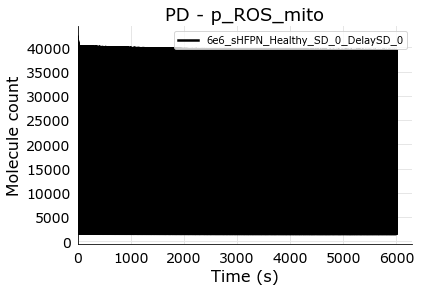



Plotting Time: 0:00:19.298682


In [14]:
##############################################################################
################Plotting Commands - BSL#######################################
##############################################################################
start_time = datetime.now()

print(calculate_mean_per_bin(File2, "p_ROS_mito",1000000))

#calculate_TRUE_calcium_stochasticity(File1)
#calculate_TRUE_calcium_stochasticity(File2)

create_plot(analysis, 
            input_place_list = ['p_ROS_mito'], 
            place_labels = [""], 
            mutation_list = [File2], 
            mutation_labels = [File2],
            plot_title = 'PD - p_ROS_mito')



# create_histogram(analysis, 20)

# calculate_mean_of_delay(analysis, File1)
# calculate_mean_of_delay(analysis, File2)

execution_time = datetime.now()-start_time
print('\n\nPlotting Time:', execution_time)
##############################################################################
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~End - BSL~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
##############################################################################  